In [1]:
pip install pmdarima



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


from sklearn.metrics import mean_squared_error, mean_absolute_error


## Load and Inspect Data

In [10]:

df = pd.read_csv("Data/processed/feature_engineered_stock_data.csv", parse_dates=["Date"], index_col="Date")
df = df.sort_index()


df = df.asfreq("B")

df["Close"].interpolate(method="linear", inplace=True)


df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1014 entries, 2020-02-11 to 2023-12-29
Freq: B
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                962 non-null    float64
 1   High                962 non-null    float64
 2   Low                 962 non-null    float64
 3   Close               1014 non-null   float64
 4   Volume              962 non-null    float64
 5   Year                962 non-null    float64
 6   Month               962 non-null    float64
 7   Day                 962 non-null    float64
 8   Weekday             962 non-null    float64
 9   Quarter             962 non-null    float64
 10  DayOfYear           962 non-null    float64
 11  Close_lag_1         962 non-null    float64
 12  Close_lag_3         962 non-null    float64
 13  Close_lag_7         962 non-null    float64
 14  Close_lag_14        962 non-null    float64
 15  Close_roll_mean_3   962 non-n

/var/folders/zp/hknxzxv91_7cvvq_f2fm158c0000gn/T/ipykernel_3984/129555235.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].interpolate(method="linear", inplace=True)


## Preprocessing

In [15]:

ts = df["Close"]


ts = ts.fillna(method="ffill")


ts = np.log(ts)


/var/folders/zp/hknxzxv91_7cvvq_f2fm158c0000gn/T/ipykernel_3984/1728500278.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method="ffill")


## Stationary Check


In [18]:
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Stationary" if result[1] < 0.05 else "Non-stationary")

adf_test(ts)


ADF Statistic: -0.0516
p-value: 0.9540
Non-stationary


## Train Test Split

In [21]:

train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]


## Fit Arima Model

In [26]:
model = auto_arima(
    train,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    trace=True
)

# Summary of model
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4246.439, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4253.945, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4251.976, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4251.972, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4253.761, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4249.996, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.689 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  811
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2128.973
Date:                Mon, 04 Aug 2025   AIC                          -4253.945
Time:                        11:13:11   BIC                          -4244.551
Sample:                    02-11-2020   HQIC                         -4250.339
    

## Forecast

In [29]:
n_periods = len(test)
forecast = model.predict(n_periods=n_periods)
forecast_index = test.index


## Plot Forcast vs Actual

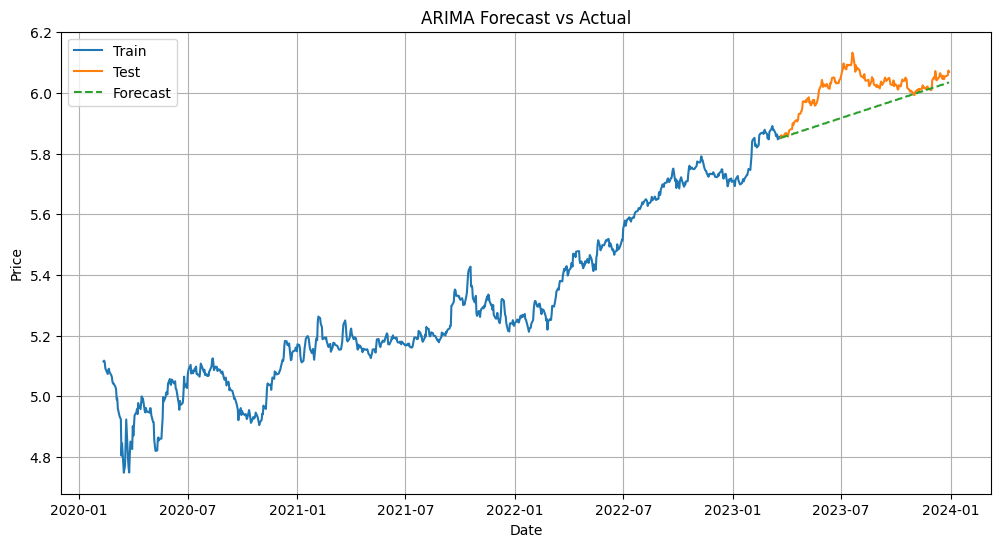

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(forecast_index, forecast, label="Forecast", linestyle="--")
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


## Evaluation Matrics

In [35]:
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")


Mean Squared Error: 0.01
Mean Absolute Error: 0.07


In [ ]:
arima_output = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast,
    'Actual': test.values
})
arima_output.to_csv("arima_forecast.csv", index=False)
print("ARIMA forecast saved to 'data/processed/arima_forecast.csv'")
